In [1]:
import deorbit

In [2]:
height_bounds = (0,100000)
models = deorbit.simulator.atmos.AtmosphereModel.__subclasses__()

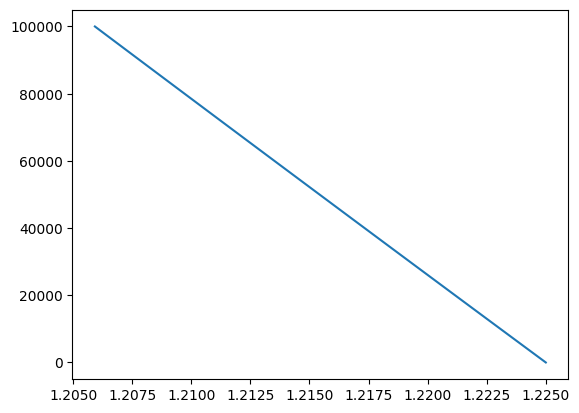

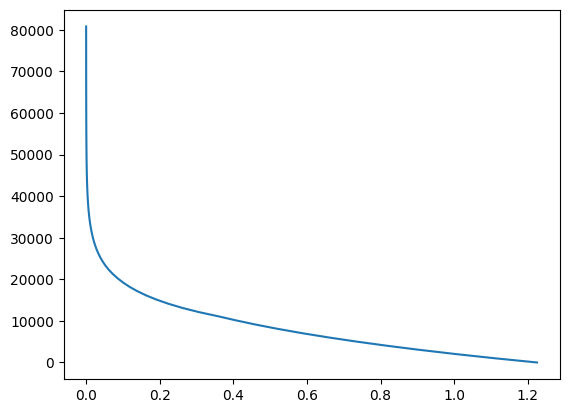

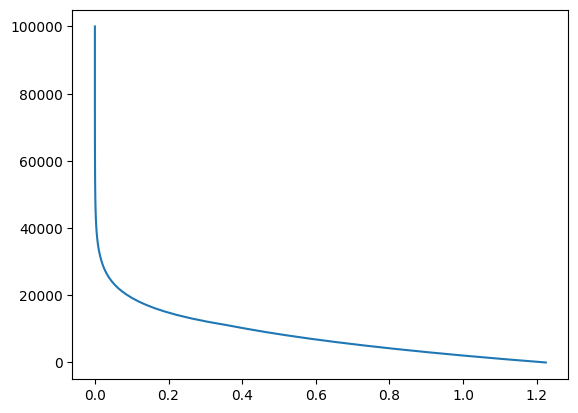

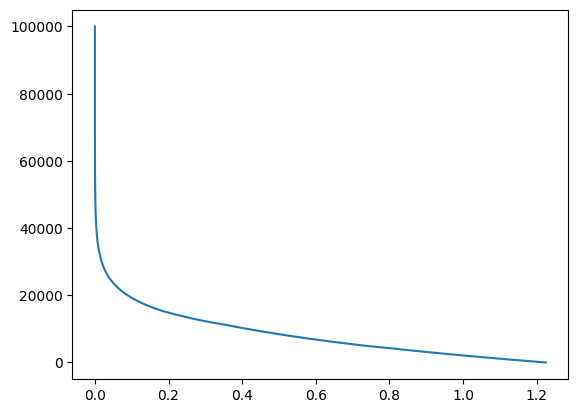

In [8]:
for model_cls in models:
    model: deorbit.simulator.atmos.AtmosphereModel = model_cls()
    model.visualize(height_bounds, num_points=100)